\newpage

# Calibration of the HBV model

In this chapter the HBV model is calibrated using the observation data. A set of parameters is used by the HBV model to model the discharge. These parameters are calibrated to make the model work for the catchment area of the Wien River. 

## Model Selection

To be able to model the expected future discharge, the Hydrologiska Byråns Vattenbalansavdelning (HBV) model is chosen. The developer of the model, Sten Bergström (1992), says the HBV model can best be classified as a semi-distributed conceptual model. The model represents a catchment area by using interconnected storage reservoirs to simulate the movement of water. By adjusting nine parameters, the HBV model can be calibrated to different catchment areas. A visual representation of the HBV model can be seen in the figure below.

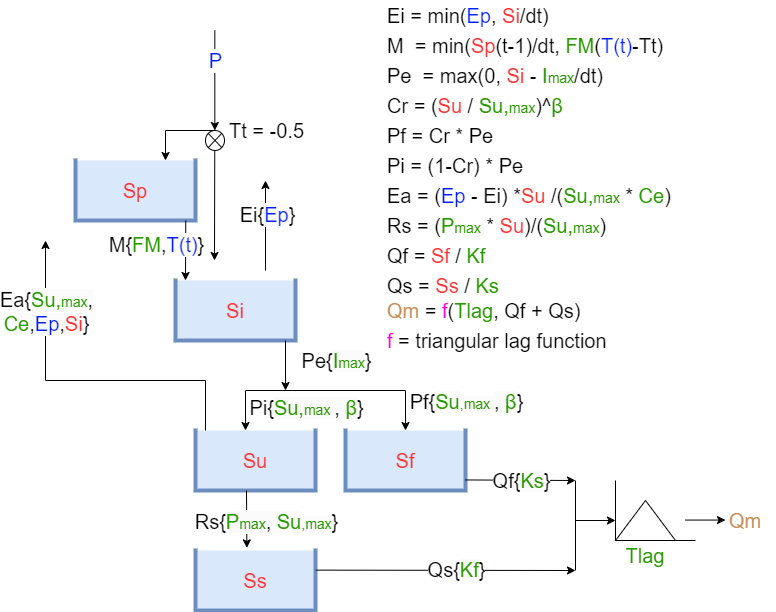

Figure 5: Layout HBV Model (Hrachowitz, M)

## Calibration

The model's performance is assesed by evaluating how well it represents the distribution of discharges, since for my research the exact timing of certain discharges and peaks is not relevant. To measure the difference between the observed and modelled discharges, the root mean squared error (RMSE) is used. The Nelder-Mead optimization is then applied to find the best set of parameters that results in the lowest RMSE. The model is trained on 75 percent of the observation data, and is then tested on 25 percent of the data. The test shows how well the model performs on data it has never seen before. It is important to choose a representative calibration- and validationset, which means that it should both contain peaks and non-peaks. Since the last 25 percent of the observation data does not contain peaks, the trainingset is chosen to be the last 75 percent of the observation data, and the validationset the first 25 percent. This ensures that both peaks and non-peaks are present in the calibration- and validationset.

### Root Mean Squared Error

The Root Mean Squared Error (RMSE) is used to calculate the average overall difference between the observed and modelled discharge. First, the difference between the observed and modelled discharge is calculated for each day, called the error. The RMSE squares this error to give more weight to large differences, such as when observed peaks are not modelled well. This method causes peaks to contribute more heavily to the RMSE. After this, the mean of all squared values is taken, before the square root is applied to get the RMSE.

### Nelder Mead Optimization 

In [1]:
# First of all, some general python and eWaterCycle libraries need to be imported:
# general python
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from scipy.optimize import minimize

#niceties
from rich import print
import seaborn as sns
sns.set()

# general eWaterCycle
import ewatercycle
import ewatercycle.models
import ewatercycle.forcing

In [2]:
# As stated in chapter 3, eWaterCycle provides access to the Caravan dataset, from which a Camel dataset of the catchment of the Wien River is loaded.
camelsgb_id = "lamah_208082"

In [3]:
# calibration dates on 75% of experiment dates

experiment_start_date = "1981-08-01T00:00:00Z"
experiment_end_date = "2018-01-01T00:00:00Z"

calibration_start_time = "1990-08-01T00:00:00Z"
calibration_end_time = experiment_end_date

validation_start_time = experiment_start_date 
validation_end_time = "1990-07-31T00:00:00Z"

In [4]:
# Even though we don't use caravan data as forcing, we still call it forcing
# because it is generated using the forcing module of eWaterCycle
forcing_path_caravan = Path.home() / "forcing" / camelsgb_id / "caravan"
forcing_path_caravan.mkdir(exist_ok=True, parents=True)

# If someone has prepared forcing for you, this path needs to be changed to that location. 
prepared_forcing_path_caravan_central = Path("location/of/forcing/data")

In [5]:
# # option one: generate forcing data
# camelsgb_forcing = ewatercycle.forcing.sources['CaravanForcing'].generate(
#     start_time=experiment_start_date,
#     end_time=experiment_end_date,
#     directory=forcing_path_caravan,
#     basin_id=camelsgb_id,
# )


# option two or three: load data that you or someone else generated previously
camelsgb_forcing = ewatercycle.forcing.sources['CaravanForcing'].load(Path("/home/thirza/forcing/lamah_208082/caravan"))

# print(camelsgb_forcing)

In [6]:
# Above, it can be seen that the forcing data contains precipitation, potential evaporation, discharge and the near-surface temperatures (tas). 
# For this research, only the discharge data is relevant. The discharge data is loaded from the forcing below, and is plotted.

#quick plot of the discharge data.
ds_forcing = xr.open_mfdataset([camelsgb_forcing['Q']])
# ds_forcing["Q"].plot()
# print(ds_forcing["time"].values)

In [7]:

#               Si,  Su, Sf, Ss, Sp
s_0 = np.array([0,  100,  0,  5, 0])
S_names = ["Interception storage", "Unsaturated Rootzone Storage", "Fastflow storage", "Slowflow storage", "Groundwater storage"]

p_names = ["$I_{max}$",  "$C_e$",  "$Su_{max}$", "β",  "$P_{max}$",  "$T_{lag}$",   "$K_f$",   "$K_s$", "FM"]
param_names = ["Imax","Ce",  "Sumax", "beta",  "Pmax",  "Tlag",   "Kf",   "Ks", "FM"]\

# p_min_initial= np.array([0,   0.2,  40,    .5,   .001,   1,     .01,  .0001,  .01])
# p_max_initial = np.array([8,    1,  800,   4,    .3,     10,    .1,   .01,  0.5])

# p_min_initial= np.array([0,   0.2,  40,    .5,   .001,   0.1,  .01,  .0001,  .01])
# p_max_initial = np.array([8,    4,  800,   4,    3,     10,    3,   .1,  5])


In [9]:
def objective_function_sorted_maximum(model_output, observation, calibration_start_time, calibration_end_time):
    calibration_start_time = pd.to_datetime(calibration_start_time)
    calibration_end_time = pd.to_datetime(calibration_end_time)

    model_output.index = model_output.index.tz_localize(None)  # Remove timezone
    observation.index = observation.index.tz_localize(None)
    calibration_start_time = calibration_start_time.tz_localize(None)
    calibration_end_time = calibration_end_time.tz_localize(None)

    # print(model_output.index)
    # print(observation.index)

    
    model_output_filtered = model_output.loc[calibration_start_time:calibration_end_time]
    obs_filtered = observation.loc[calibration_start_time:calibration_end_time]
    # obs_filtered = observation.loc[(calibration_start_time + pd.Timedelta(days=1)) : calibration_end_time]

    
    # Sort data from high to low
    sorted_model_data = np.sort(model_output_filtered)[::-1]  # Sorteer aflopend
    sorted_obs_data = np.sort(obs_filtered)[::-1]
    
    #calculate return periods
    m = len(sorted_model_data)
    rank = np.arange(1, m + 1)
    return_periods_days_model = (m + 1) / rank
    return_periods_years_model = return_periods_days_model / 365.25
    
    
    m = len(sorted_obs_data)
    rank = np.arange(1, m + 1)
    return_periods_days_obs = (m + 1) / rank
    return_periods_years_obs = return_periods_days_obs / 365.25

    # sorted_model_data_subset = sorted_model_data[return_periods_years_model >= 0]
    # sorted_obs_data_subset = sorted_obs_data[return_periods_years_obs >= 0]
    sorted_model_data_subset = sorted_model_data
    sorted_obs_data_subset = sorted_obs_data

    
    if len(sorted_model_data_subset) != len(sorted_obs_data_subset):
        print(len(sorted_model_data_subset), len(sorted_obs_data_subset))
        raise ValueError("observation and data not equal length")

    objective_this_model = np.sqrt(np.mean((sorted_model_data_subset - sorted_obs_data_subset)**2))

    return objective_this_model

In [11]:
######## NEW

Q_pandas = ds_forcing["Q"].to_dataframe()
# obs_all_dataframe = ds_forcing.to_dataframe() 
# obs_series = obs_all_dataframe["Q"]

def optimization_function(parameter_vector):
    model = ewatercycle.models.HBVLocal(forcing=camelsgb_forcing)
    config_file, _ = model.setup(            parameters = parameter_vector,
                            initial_storage=s_0,
                            cfg_dir = "configFiles/hbv_ensembleMember_",
                               )
    model.initialize(config_file)


   # discharge_this_timestep = model.get_value("Q") 
    Q_m = []
    time = []
    while model.time < model.end_time:
        model.update()
        discharge_this_timestep = model.get_value("Q")
        Q_m.append(discharge_this_timestep[0])
        time.append(pd.Timestamp(model.time_as_datetime.date()))
   # model.finalize()
   # print(model.get_value("Q"))
    
    #calculate the objective function 
    discharge_series = pd.Series(data=Q_m, name="Modelled_discharge", index=time)
   # print(len(discharge_series), len(Q_m), len(time), len(obs_series))
    objective_this_model = objective_function_sorted_maximum(discharge_series,Q_pandas["Q"] ,calibration_start_time, calibration_end_time)
    del Q_m, time, discharge_series
   
    if np.isnan(objective_this_model):
        return np.inf
    
    return objective_this_model

In [12]:
# bounds = [(0, None), (0.001, None),(0.001, None),(0.001, None),(0.001, None),(0.001, None),(0.001, None),(0.001, None),(0.001, None)]

# result = minimize(optimization_function, [7.70574780e-07, 1.32351315e+00, 1.00047603e+02, 3.89427105e+00,
#        6.66366529e-01, 4.30576783e-02, 1.00508560e+00, 1.94023052e+00,
#        4.58706486e-01], bounds=bounds, method='Nelder-Mead', options={'maxiter':3000})

In [13]:
# result

In [14]:
# result.x
# 90/10
# # result = [6.51669781e-05, 6.38655600e-01, 5.30024294e+01, 1.56641841e+00,
# #        1.10734080e+00, 1.49999999e+00, 5.50209588e-01, 3.74966606e-02,
# #        1.04773070e+00]

# 70/30
# result = [5.15724216e-05, 8.36587345e-01, 3.90778393e+01, 3.57466531e+00,
#        1.06383450e+00, 9.37562028e-01, 3.02412699e-01, 8.15566365e-02,
#        2.90551458e+00]

# result = [4.00431542e-07, 1.18207742e+00, 6.18107025e+01, 3.43810639e+00,
#        1.46429514e+00, 1.50000000e+00, 6.12583301e-01, 2.73318870e-03,
#        7.95615325e-01]


# result = [7.70574780e-07, 1.32351315e+00, 1.00047603e+02, 3.89427105e+00,
#        6.66366529e-01, 4.30576783e-02, 1.00508560e+00, 1.94023052e+00,
#        4.58706486e-01]

result = [1.46408246e-07, 8.68881909e-01, 1.02507886e+02, 2.20192834e+00,
       1.05791079e+00, 1.84223360e-01, 1.15943798e+00, 1.59419229e+00,
       5.97650513e-01]

In [15]:
# result.fun
# 90/10
# # objective = 0.027397519552779696

# 70/30
# objective = 0.01965939310646257



In [16]:
par = result
model = ewatercycle.models.HBVLocal(forcing=camelsgb_forcing)
config_file, _ = model.setup(parameters=par, initial_storage=s_0)
model.initialize(config_file)


In [17]:
Q_m = []
time = []
while model.time < model.end_time:
    model.update()
    Q_m.append(model.get_value("Q")[0])
    time.append(pd.Timestamp(model.time_as_datetime))
model.finalize()

In [18]:
model_output = pd.Series(data=Q_m, name="Modelled_discharge", index=time)

Text(0, 0.5, 'Discharge (mm/d)')

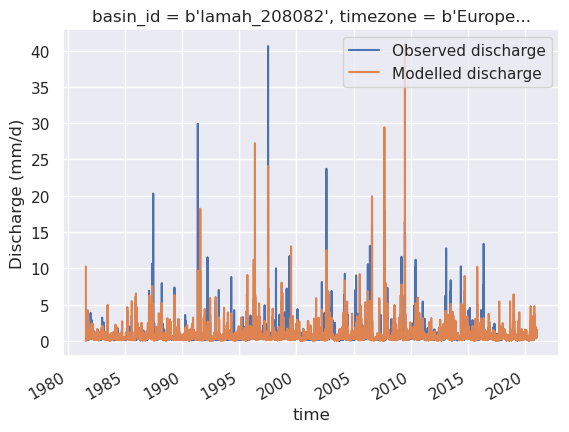

In [19]:
ds_forcing["Q"].plot(label="Observed discharge")
model_output.plot(label="Modelled discharge")
plt.legend()
plt.ylabel("Discharge (mm/d)")

In [20]:
df = pd.DataFrame(model_output)

calibration_start_time = pd.to_datetime(calibration_start_time)
calibration_end_time = pd.to_datetime(calibration_end_time)

df.index = df.index.tz_localize(None)  # Remove timezone
Q_pandas.index = Q_pandas.index.tz_localize(None)
calibration_start_time = calibration_start_time.tz_localize(None)
calibration_end_time = calibration_end_time.tz_localize(None)

model_output_filtered = model_output.loc[calibration_start_time:calibration_end_time]
ds_forcing_filtered = ds_forcing["Q"].loc[calibration_start_time:calibration_end_time]

Text(0, 0.5, 'Discharge (mm/d)')

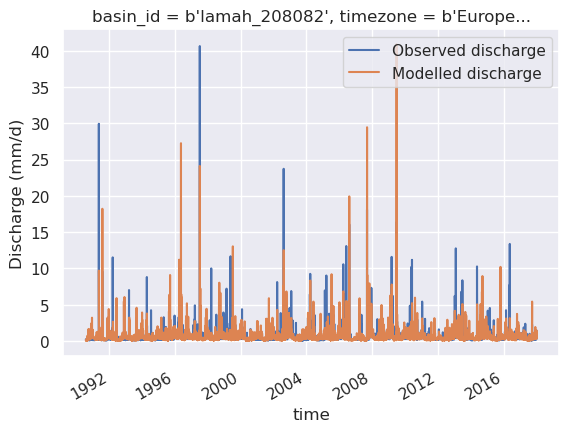

In [21]:
ds_forcing_filtered.plot(label="Observed discharge")
model_output_filtered.plot(label="Modelled discharge")
plt.legend()
plt.ylabel("Discharge (mm/d)")

Text(0, 0.5, 'Discharge (mm/day)')

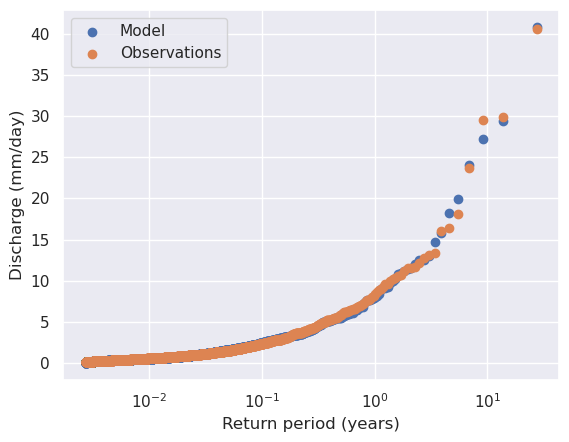

In [22]:
# Sort data from high to low
sorted_model_data = np.sort(model_output_filtered)[::-1]  # Sorteer aflopend
ds_forcing_filtered = np.sort(ds_forcing_filtered)[::-1]

#calculate return periods
m = len(sorted_model_data)
rank = np.arange(1, m + 1)
return_periods_days_model = (m + 1) / rank
return_periods_years_model = return_periods_days_model / 365.25


m = len(ds_forcing_filtered)
rank = np.arange(1, m + 1)
return_periods_days_obs = (m + 1) / rank
return_periods_years_obs = return_periods_days_obs / 365.25

plt.xscale('log')
plt.scatter(return_periods_years_model, sorted_model_data, label='Model')
plt.scatter(return_periods_years_obs, ds_forcing_filtered, label='Observations')
plt.legend()
plt.xlabel('Return period (years)')
plt.ylabel('Discharge (mm/day)')

In [23]:
validation_start_time = pd.to_datetime(validation_start_time)
validation_end_time = pd.to_datetime(validation_end_time)

df.index = df.index.tz_localize(None)  # Remove timezone
Q_pandas.index = Q_pandas.index.tz_localize(None)
validation_start_time = validation_start_time.tz_localize(None)
validation_end_time = validation_end_time.tz_localize(None)
# Filter de modeloutput voor de geselecteerde periode
model_output_filtered = model_output.loc[validation_start_time:validation_end_time]

# Als je ook de waargenomen afvoer wilt filteren, doe je hetzelfde:
ds_forcing_filtered = ds_forcing["Q"].loc[validation_start_time:validation_end_time]

Text(0, 0.5, 'Discharge (mm/d)')

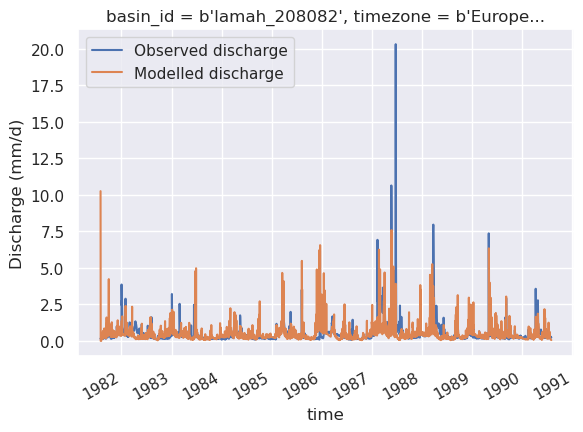

In [24]:
ds_forcing_filtered.plot(label="Observed discharge")
model_output_filtered.plot(label="Modelled discharge")
plt.legend()
plt.ylabel("Discharge (mm/d)")

Text(0, 0.5, 'Discharge (mm/day)')

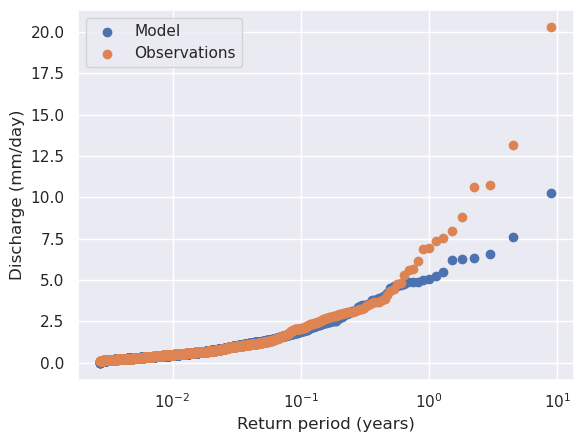

In [25]:
# Sort data from high to low
sorted_model_data = np.sort(model_output_filtered)[::-1]  # Sorteer aflopend
ds_forcing_filtered = np.sort(ds_forcing_filtered)[::-1]

#calculate return periods
m = len(sorted_model_data)
rank = np.arange(1, m + 1)
return_periods_days_model = (m + 1) / rank
return_periods_years_model = return_periods_days_model / 365.25


m = len(ds_forcing_filtered)
rank = np.arange(1, m + 1)
return_periods_days_obs = (m + 1) / rank
return_periods_years_obs = return_periods_days_obs / 365.25

plt.xscale('log')
plt.scatter(return_periods_years_model, sorted_model_data, label='Model')
plt.scatter(return_periods_years_obs, ds_forcing_filtered, label='Observations')
plt.legend()
plt.xlabel('Return period (years)')
plt.ylabel('Discharge (mm/day)')

To be able to compare the model output to the observation data, the model output is converted from mm/day to m3/s as well. This is plotted below.

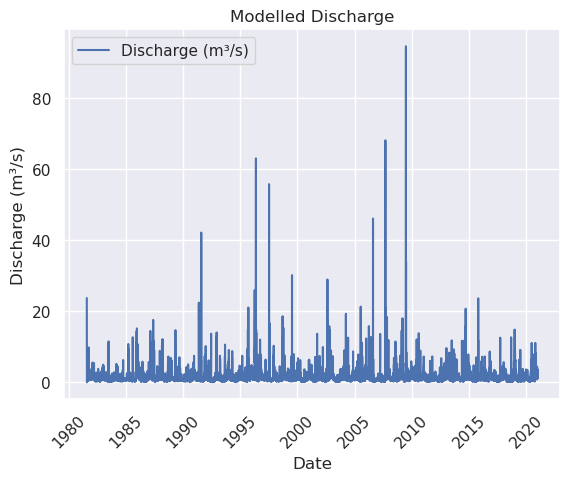

In [26]:
catchment_area = ds_forcing["area"].values


model_data = df['Modelled_discharge'] * catchment_area * 1000 / (24 * 60 * 60)

plt.plot(df.index, model_data, label='Discharge (m³/s)')

plt.xlabel('Date')
plt.ylabel('Discharge (m³/s)')
plt.title('Modelled Discharge')
plt.xticks(rotation=45)  # Draai de datums voor betere leesbaarheid
plt.legend()

plt.savefig("/home/thirza/BEPproject/book/Grafieken/modelleddischarge.png", dpi=300)
plt.show()

For a mean threshold value of 530 m3/s, the return period is 772.887 years for fit all data

For a mean threshold value of 534 m3/s, the return period is 783.831 years for fit all data

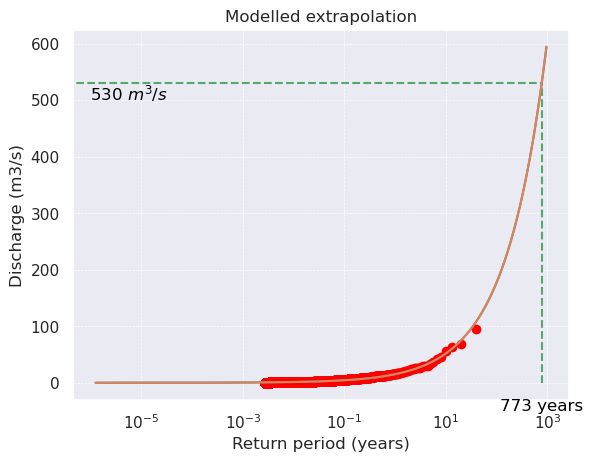

In [27]:
from scipy.optimize import curve_fit
from scipy.optimize import fsolve

# Sort data from high to low
sorted_model_data = np.sort(model_data)[::-1]  # Sorteer aflopend

#calculate return periods
m = len(sorted_model_data)
rank = np.arange(1, m + 1)
return_periods_days_model = (m + 1) / rank
return_periods_years_model = return_periods_days_model / 365


# # 0.5 because we want to extrapolate the peaks, so look at discharges that occure 2 times a year or more
# return_periods_years_model_subset = return_periods_years_model[return_periods_years_model >= 0.5]
# sorted_model_data_subset = sorted_model_data[return_periods_years_model >= 0.5]

def power_law(x, a, b):
    return a * x ** b

def calculate_return_periods(sorted_model_data):
    n = len(sorted_model_data)
    rank = np.arange(1, n + 1)
    return_periods_days = (n + 1) / rank
    return_periods_years = return_periods_days / 365.25
    
    # Alleen de data voor returnperioden >= 0 behouden
    return_periods_years_subset = return_periods_years[return_periods_years >= 0]
    sorted_data_subset = sorted_model_data[return_periods_years >= 0]

    # Fit de power law functie
    params, _ = curve_fit(power_law, return_periods_years_subset, sorted_data_subset, maxfev=10000)
    a_opt, b_opt = params

    x_fit = np.logspace(np.log(min(return_periods_years_subset)), np.log(max(return_periods_years_subset)/2), 1000)
    y_fit = power_law(x_fit, a_opt, b_opt)

    return x_fit, y_fit, a_opt, b_opt

x_fit, y_fit, a_opt, b_opt = calculate_return_periods(sorted_model_data)

def find_x_for_y(y_target, a, b):
    return (y_target / a) ** (1 / b)
y_target = 530
x_value = find_x_for_y(y_target, a_opt, b_opt)
print(f"For a mean threshold value of {y_target} m3/s, the return period is {x_value:.3f} years for fit all data")

plt.hlines(y_target, xmin=0, xmax=x_value, colors='g', linestyles='dashed', label="y=530 Line")
plt.vlines(x_value, ymin=0, ymax=y_target, colors='g', linestyles='dashed', label="Intersection to x-axis")
plt.text(x_value, -50, f'{x_value:.0f} years', ha='center', fontsize=12, color='black')
plt.text(0.000001, y_target, f'{y_target:.0f} $m^3/s$', va='top', fontsize=12, color='black')

y_target = 534
x_value = find_x_for_y(y_target, a_opt, b_opt)
print(f"For a mean threshold value of {y_target} m3/s, the return period is {x_value:.3f} years for fit all data")
plt.plot(x_fit, y_fit, label=f'Fit all data')

plt.xscale('log')
plt.scatter(return_periods_years_model, sorted_model_data, color="red", label="Waarden")
plt.plot(x_fit, y_fit)
plt.xlabel('Return period (years)')
plt.ylabel('Discharge (m3/s)')




plt.title('Modelled extrapolation')
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

# plt.savefig("/home/thirza/BEPproject/book/Grafieken/Scatter.png", dpi=300)

In [28]:
df['Modelled_discharge'].dropna(inplace=True)
Q_pandas["Q"].dropna(inplace=True)

validation_start_time = pd.to_datetime(validation_start_time)
validation_end_time = pd.to_datetime(validation_end_time)

# validation_start_time = (validation_start_time + pd.Timedelta(days=1))

df.index = df.index.tz_localize(None)
Q_pandas.index = Q_pandas.index.tz_localize(None)
validation_start_time = validation_start_time.tz_localize(None)
validation_end_time = validation_end_time.tz_localize(None)

df_filtered = df[(df.index >= validation_start_time) & (df.index <= validation_end_time + pd.Timedelta(days=1))]
Q_filtered = Q_pandas[(Q_pandas.index >= validation_start_time) & (Q_pandas.index <= validation_end_time)]

print(f'The objective for the validation period is {objective_function_sorted_maximum(df['Modelled_discharge'], Q_pandas["Q"], validation_start_time + pd.Timedelta(days=1), validation_end_time)}')

The objective for the validation period is 0.2482338892810459

In [29]:
print(f'The objective for the calibration period is {objective_function_sorted_maximum(df['Modelled_discharge'], Q_pandas["Q"], calibration_start_time + pd.Timedelta(days=1), calibration_end_time)}')

The objective for the calibration period is 0.05484056582032742